In [22]:
from pyspark.sql import SparkSession

from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import *

from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import OneHotEncoder, StandardScaler, VectorAssembler, StringIndexer, Imputer

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#create Spark session
spark = SparkSession.builder.appName('model_flight_delay').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '10g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '8'), ('spark.cores.max', '4'), ('spark.driver.memory','10g')])


In [3]:
# load the data
train_df = spark.read \
        .option("quote", "\"")  \
        .option("escape", "\"") \
        .option("ignoreLeadingWhiteSpace",True) \
        .csv("gs://mscabigdata7fall2022/train_set_2018_2021.csv",inferSchema=True, header=True )

In [4]:
test_df = spark.read \
        .option("quote", "\"")  \
        .option("escape", "\"") \
        .option("ignoreLeadingWhiteSpace",True) \
        .csv("gs://mscabigdata7fall2022/train_set_2022.csv",inferSchema=True, header=True )

In [5]:
# # create subset of data for first round modeling
# # train_df.limit(5000).write.csv('gs://airline_project/train_sample.csv', mode="overwrite", header=True)

# # read the sample train data
# train_df = spark.read \
#         .option("quote", "\"")  \
#         .option("escape", "\"") \
#         .option("ignoreLeadingWhiteSpace",True) \
#         .csv("gs://airline_project/train_sample.csv",inferSchema=True, header=True )

In [11]:
# Check the frequency of cancellation
# train_df.select('Cancelled').groupby('Cancelled').count().show()

+---------+--------+
|Cancelled|   count|
+---------+--------+
|     true| 2579160|
|    false|70703968|
+---------+--------+



In [6]:
# data type conversion
from pyspark.sql.functions import col, to_timestamp
from pyspark.sql.types import IntegerType, BooleanType, StringType, DateType, DoubleType

train_df = train_df.withColumn("ORIGIN_HourlyDryBulbTemperature", train_df.ORIGIN_HourlyDryBulbTemperature.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyPrecipitation", train_df.ORIGIN_HourlyPrecipitation.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyStationPressure", train_df.ORIGIN_HourlyStationPressure.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyVisibility", train_df.ORIGIN_HourlyVisibility.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyWindDirection", train_df.ORIGIN_HourlyWindDirection.cast(IntegerType()))\
        .withColumn("DEST_HourlyDryBulbTemperature", train_df.DEST_HourlyDryBulbTemperature.cast(DoubleType()))\
        .withColumn("DEST_HourlyPrecipitation", train_df.DEST_HourlyPrecipitation.cast(DoubleType()))\
        .withColumn("DEST_HourlyStationPressure", train_df.DEST_HourlyStationPressure.cast(DoubleType()))\
        .withColumn("DEST_HourlyVisibility", train_df.DEST_HourlyVisibility.cast(DoubleType()))\
        .withColumn("DEST_HourlyWindDirection", train_df.DEST_HourlyWindDirection.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlyAltimeterSetting", train_df.ORIGIN_HourlyAltimeterSetting.cast(DoubleType()))\
        .withColumn("DEST_HourlyAltimeterSetting", train_df.DEST_HourlyAltimeterSetting.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyDewPointTemperature", train_df.ORIGIN_HourlyDewPointTemperature.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlyPressureChange", train_df.ORIGIN_HourlyPressureChange.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyRelativeHumidity", train_df.ORIGIN_HourlyRelativeHumidity.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlySeaLevelPressure", train_df.ORIGIN_HourlySeaLevelPressure.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyWetBulbTemperature", train_df.ORIGIN_HourlyWetBulbTemperature.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlyWindGustSpeed", train_df.ORIGIN_HourlyWindGustSpeed.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlyWindSpeed", train_df.ORIGIN_HourlyWindSpeed.cast(IntegerType()))\
        .withColumn("DEST_HourlyDewPointTemperature", train_df.DEST_HourlyDewPointTemperature.cast(IntegerType()))\
        .withColumn("DEST_HourlyPressureChange", train_df.DEST_HourlyPressureChange.cast(DoubleType()))\
        .withColumn("DEST_HourlyRelativeHumidity", train_df.DEST_HourlyRelativeHumidity.cast(IntegerType()))\
        .withColumn("DEST_HourlySeaLevelPressure", train_df.DEST_HourlySeaLevelPressure.cast(DoubleType()))\
        .withColumn("DEST_HourlyWetBulbTemperature", train_df.DEST_HourlyWetBulbTemperature.cast(IntegerType()))\
        .withColumn("DEST_HourlyWindGustSpeed", train_df.DEST_HourlyWindGustSpeed.cast(IntegerType()))\
        .withColumn("DEST_HourlyWindSpeed", train_df.DEST_HourlyWindSpeed.cast(IntegerType()))\
        .withColumn("Cancelled", train_df.Cancelled.cast(StringType()))

train_df.printSchema()

root
 |-- FlightDate: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: timestamp (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DOT_ID_Marketing_Airline: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- DestAirportSeqID: integer (nullable = true)
 |-- CRSArrTime: timestamp (nullable = true)
 |-- OriginStation: long (nullable = true)
 |-- DestStation: long (nullable = true)
 |-- ORIGIN_Station: long (nullable = true)
 |-- ORIGIN_NAME: string (nullable = true)
 |-- ORIGIN_HourlyAltimeterSetting: double (nullable = true)
 |-- ORIGIN_HourlyDewPointTemperature: integer (nullable = true)
 |-- ORIGIN_HourlyDryBulbTemperature: double (nullable = true)
 |-- ORIGIN_HourlyPrecipitation: double (nullable = true)
 |-- ORIGIN_HourlyPresentWeatherType: string (nullable = true)
 |-- ORIGIN_Hourly

In [7]:
test_df = test_df.withColumn("ORIGIN_HourlyDryBulbTemperature", test_df.ORIGIN_HourlyDryBulbTemperature.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyPrecipitation", test_df.ORIGIN_HourlyPrecipitation.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyStationPressure", test_df.ORIGIN_HourlyStationPressure.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyVisibility", test_df.ORIGIN_HourlyVisibility.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyWindDirection", test_df.ORIGIN_HourlyWindDirection.cast(IntegerType()))\
        .withColumn("DEST_HourlyDryBulbTemperature", test_df.DEST_HourlyDryBulbTemperature.cast(DoubleType()))\
        .withColumn("DEST_HourlyPrecipitation", test_df.DEST_HourlyPrecipitation.cast(DoubleType()))\
        .withColumn("DEST_HourlyStationPressure", test_df.DEST_HourlyStationPressure.cast(DoubleType()))\
        .withColumn("DEST_HourlyVisibility", test_df.DEST_HourlyVisibility.cast(DoubleType()))\
        .withColumn("DEST_HourlyWindDirection", test_df.DEST_HourlyWindDirection.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlyAltimeterSetting", test_df.ORIGIN_HourlyAltimeterSetting.cast(DoubleType()))\
        .withColumn("DEST_HourlyAltimeterSetting", test_df.DEST_HourlyAltimeterSetting.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyDewPointTemperature", test_df.ORIGIN_HourlyDewPointTemperature.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlyPressureChange", test_df.ORIGIN_HourlyPressureChange.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyRelativeHumidity", test_df.ORIGIN_HourlyRelativeHumidity.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlySeaLevelPressure", test_df.ORIGIN_HourlySeaLevelPressure.cast(DoubleType()))\
        .withColumn("ORIGIN_HourlyWetBulbTemperature", test_df.ORIGIN_HourlyWetBulbTemperature.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlyWindGustSpeed", test_df.ORIGIN_HourlyWindGustSpeed.cast(IntegerType()))\
        .withColumn("ORIGIN_HourlyWindSpeed", test_df.ORIGIN_HourlyWindSpeed.cast(IntegerType()))\
        .withColumn("DEST_HourlyDewPointTemperature", test_df.DEST_HourlyDewPointTemperature.cast(IntegerType()))\
        .withColumn("DEST_HourlyPressureChange", test_df.DEST_HourlyPressureChange.cast(DoubleType()))\
        .withColumn("DEST_HourlyRelativeHumidity", test_df.DEST_HourlyRelativeHumidity.cast(IntegerType()))\
        .withColumn("DEST_HourlySeaLevelPressure", test_df.DEST_HourlySeaLevelPressure.cast(DoubleType()))\
        .withColumn("DEST_HourlyWetBulbTemperature", test_df.DEST_HourlyWetBulbTemperature.cast(IntegerType()))\
        .withColumn("DEST_HourlyWindGustSpeed", test_df.DEST_HourlyWindGustSpeed.cast(IntegerType()))\
        .withColumn("DEST_HourlyWindSpeed", test_df.DEST_HourlyWindSpeed.cast(IntegerType()))\
        .withColumn("Cancelled", test_df.Cancelled.cast(StringType()))

test_df.printSchema()

root
 |-- FlightDate: string (nullable = true)
 |-- Cancelled: string (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- CRSDepTime: timestamp (nullable = true)
 |-- Distance: double (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DOT_ID_Marketing_Airline: integer (nullable = true)
 |-- OriginAirportSeqID: integer (nullable = true)
 |-- DestAirportSeqID: integer (nullable = true)
 |-- CRSArrTime: timestamp (nullable = true)
 |-- OriginStation: long (nullable = true)
 |-- DestStation: long (nullable = true)
 |-- ORIGIN_Station: long (nullable = true)
 |-- ORIGIN_NAME: string (nullable = true)
 |-- ORIGIN_HourlyAltimeterSetting: double (nullable = true)
 |-- ORIGIN_HourlyDewPointTemperature: integer (nullable = true)
 |-- ORIGIN_HourlyDryBulbTemperature: double (nullable = true)
 |-- ORIGIN_HourlyPrecipitation: double (nullable = true)
 |-- ORIGIN_HourlyPresentWeatherType: string (nullable = true)
 |-- ORIGIN_Hourly

In [46]:
# train_df.count()

1019314

## Random Forest

In [8]:
# selecting features

feature_lst = [
 'Cancelled',
 'Distance',
 'ORIGIN_HourlyAltimeterSetting',
 'ORIGIN_HourlyDewPointTemperature',
 'ORIGIN_HourlyDryBulbTemperature',
 'ORIGIN_HourlyPrecipitation',
 'ORIGIN_HourlyPressureChange',
 'ORIGIN_HourlyPressureTendency',
 'ORIGIN_HourlyRelativeHumidity',
 'ORIGIN_HourlySkyConditions',
 'ORIGIN_HourlySeaLevelPressure',
 'ORIGIN_HourlyStationPressure',
 'ORIGIN_HourlyVisibility',
 'ORIGIN_HourlyWetBulbTemperature',
 'ORIGIN_HourlyWindDirection',
 'ORIGIN_HourlyWindGustSpeed',
 'ORIGIN_HourlyWindSpeed',
#  'ORIGIN_hourly_timestamp',
#  'DEST_HourlyAltimeterSetting',
#  'DEST_HourlyDewPointTemperature',
#  'DEST_HourlyDryBulbTemperature',
#  'DEST_HourlyPrecipitation',
#  'DEST_HourlyPressureChange',
#  'DEST_HourlyPressureTendency',
#  'DEST_HourlyRelativeHumidity',
#  'DEST_HourlySkyConditions',
#  'DEST_HourlySeaLevelPressure',
#  'DEST_HourlyStationPressure',
#  'DEST_HourlyVisibility',
#  'DEST_HourlyWetBulbTemperature',
#  'DEST_HourlyWindDirection',
#  'DEST_HourlyWindGustSpeed',
#  'DEST_HourlyWindSpeed',
#  'DEST_hourly_timestamp',
 'emp_per_flight',
 'fulltime_pct',
#     'airline',
#     'OriginAirportSeqID',
#     'DestAirportSeqID',
#     'DayofMonth',
#     'DayOfWeek'
]

train_df = train_df.select(feature_lst)

In [9]:
# data preprocessing
string_var = ['OriginAirportSeqID', 'DestAirportSeqID', 'ORIGIN_HourlySkyConditions', 
              'DEST_HourlySkyConditions', 'airline']

numeric_var = [i for i in train_df.columns if (i not in string_var and i != 'Cancelled')]

pipe_stages= []

# all string(categorical) variables will be encoded into numbers

labelIndexer = StringIndexer(inputCol="Cancelled", outputCol="LabelCancelled")
pipe_stages += [labelIndexer]

# stringIndexer= StringIndexer(inputCols= string_var, 
#                         outputCols= ["indexed_{}".format(item) for item in string_var],
#                         handleInvalid='keep',
#                         stringOrderType='frequencyDesc')
# pipe_stages += [stringIndexer]

# assembler= VectorAssembler(inputCols= ["indexed_{}".format(item) for item in string_var] + numeric_var,
#                            outputCol= "features",
#                            handleInvalid="keep")
assembler= VectorAssembler(inputCols= numeric_var,
                           outputCol= "features",
                           handleInvalid="keep")

pipe_stages += [assembler]

pipe= Pipeline(stages= pipe_stages)

In [10]:
numeric_var

['Distance',
 'ORIGIN_HourlyAltimeterSetting',
 'ORIGIN_HourlyDewPointTemperature',
 'ORIGIN_HourlyDryBulbTemperature',
 'ORIGIN_HourlyPrecipitation',
 'ORIGIN_HourlyPressureChange',
 'ORIGIN_HourlyPressureTendency',
 'ORIGIN_HourlyRelativeHumidity',
 'ORIGIN_HourlySeaLevelPressure',
 'ORIGIN_HourlyStationPressure',
 'ORIGIN_HourlyVisibility',
 'ORIGIN_HourlyWetBulbTemperature',
 'ORIGIN_HourlyWindDirection',
 'ORIGIN_HourlyWindGustSpeed',
 'ORIGIN_HourlyWindSpeed',
 'emp_per_flight',
 'fulltime_pct']

In [11]:
train_df= pipe.fit(train_df).transform(train_df)

In [12]:
test_df= pipe.fit(test_df).transform(test_df)

In [ ]:
# train_df.show(1)

In [ ]:
# # train test split
# train_set, test_set = train_df.randomSplit(weights=[0.8,0.2], seed=123)
# print(train_set.count(), test_set.count())

In [13]:
# add weight column
# weight column
from pyspark.sql.functions import col
from pyspark.sql.functions import when

# Counts
count_F = train_df[train_df['LabelCancelled']==0].count()
count_total = train_df.count()

# Weights
c = 2
weight_F = count_total / (c * count_F)
weight_Y = count_total / (c * (count_total - count_F))

In [14]:
train_df = train_df.withColumn("weight", when(col("LabelCancelled") ==0, weight_F).otherwise(weight_Y))
train_df.select('LabelCancelled', 'weight').show(3)

+--------------+------------------+
|LabelCancelled|            weight|
+--------------+------------------+
|           0.0|0.5182391460688599|
|           0.0|0.5182391460688599|
|           0.0|0.5182391460688599|
+--------------+------------------+
only showing top 3 rows



In [32]:
# build up the model
# best: numTrees:  200 maxDepth:  8 maxBins:  128
rfc= RandomForestClassifier(numTrees=200,
                            maxDepth=8, 
                            maxBins=128,
                            labelCol='LabelCancelled', 
                            featuresCol='features',
                            weightCol='weight',
                            seed=42)

In [33]:
# bce= BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction",
#                                    labelCol="LabelCancelled", 
#                                    metricName= "areaUnderROC")

In [34]:
# train_set_sub = train_set.sample(withReplacement=False, fraction=0.01, seed=42)

In [ ]:
rfc_model= rfc.fit(train_df)

22/11/30 02:48:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1623.3 KiB
22/11/30 02:58:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/11/30 03:10:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/11/30 03:24:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1631.4 KiB


In [33]:
# save the model
# rfc_model.save('gs://airline_project/rf_model1')
rfc_model.write().overwrite().save('gs://airline_project/rf_model_weighted_full')

22/11/29 09:06:55 WARN org.apache.spark.scheduler.TaskSetManager: Stage 64 contains a task of very large size (2030 KiB). The maximum recommended task size is 1000 KiB.


In [23]:
# load the model
# rfc_model.load('gs://airline_project/rf_model1')
rfc_model = RandomForestClassificationModel.load('gs://airline_project/rf_model_weighted_full')

In [36]:
# evaluate the model
preds= rfc_model.transform(test_df) 
                                   
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#print evaluation metrics
evaluator = MulticlassClassificationEvaluator(labelCol="LabelCancelled", predictionCol="prediction")

print(evaluator.evaluate(preds, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(preds, {evaluator.metricName: "f1"}))

22/11/30 03:40:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1958.6 KiB
22/11/30 03:41:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1958.6 KiB


0.95743896660192


0.9366223213296091


In [88]:
# bce.evaluate(preds) 

In [91]:
preds.filter((preds['labelCancelled']==1) & (preds['prediction'] == 0))\
    .select('Cancelled', 'labelCancelled','rawPrediction', 'probability', 'prediction').show(3, truncate = False)

22/11/28 00:18:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.2 MiB


+---------+--------------+--------------------------------------+---------------------------------------+----------+
|Cancelled|labelCancelled|rawPrediction                         |probability                            |prediction|
+---------+--------------+--------------------------------------+---------------------------------------+----------+
|true     |1.0           |[312.3745659181282,187.62543408187128]|[0.624749131836257,0.3752508681637429] |0.0       |
|true     |1.0           |[333.31401944502005,166.6859805549801]|[0.66662803889004,0.3333719611099601]  |0.0       |
|true     |1.0           |[342.840377408486,157.1596225915144]  |[0.6856807548169714,0.3143192451830285]|0.0       |
+---------+--------------+--------------------------------------+---------------------------------------+----------+
only showing top 3 rows



In [37]:
from pyspark.mllib.evaluation import MulticlassMetrics

preds_float= preds\
.select("prediction", "labelCancelled")\
.withColumn("labelCancelled", f.col("labelCancelled").cast(FloatType()))\
.orderBy("prediction")

cm= MulticlassMetrics(preds_float.rdd.map(tuple))

#print(cm.confusionMatrix().toArray())

#show the confusion matrix as a pandas df for clearer presentation
pd.DataFrame(cm.confusionMatrix().toArray(),
             columns= ["predicted negative", "predicted positive"],
             index= ["true negative", "true positive"])

22/11/30 03:42:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1937.4 KiB
22/11/30 03:43:27 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1939.3 KiB
22/11/30 03:44:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1931.6 KiB
22/11/30 03:44:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1941.8 KiB


,predicted negative,predicted positive
true negative,12339130.0,0.0
true positive,548512.0,15.0


In [26]:
sparse= rfc_model.featureImportances
vals= sparse.values
idx= sparse.indices
feature_names= numeric_var
importances_df= pd.DataFrame(zip(feature_names, vals), columns=["feature", "value"])

In [38]:
importances_df.sort_values(by=['value'], inplace=True)

[(0.0, 0.25)]

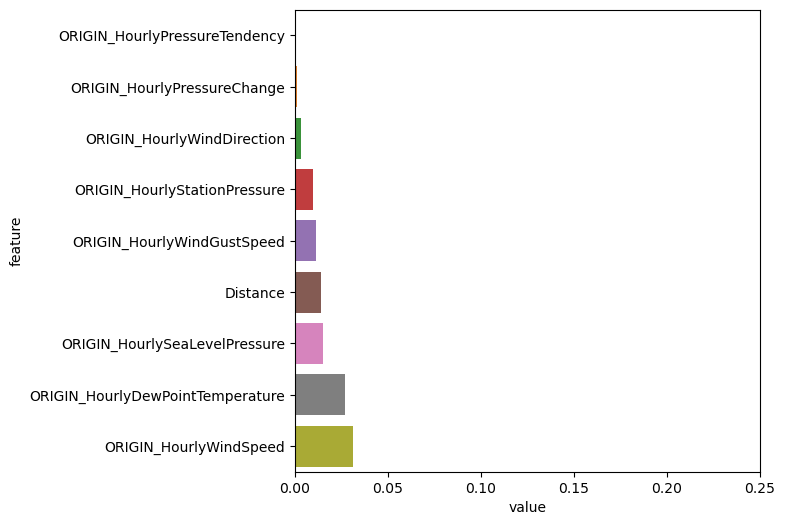

In [39]:
# feature importance
import seaborn as sns
plt.figure(figsize=(6,6))
sns.barplot(data=importances_df[:9], x='value', y='feature').set(xlim=(0,0.25))

[(0.0, 0.25)]

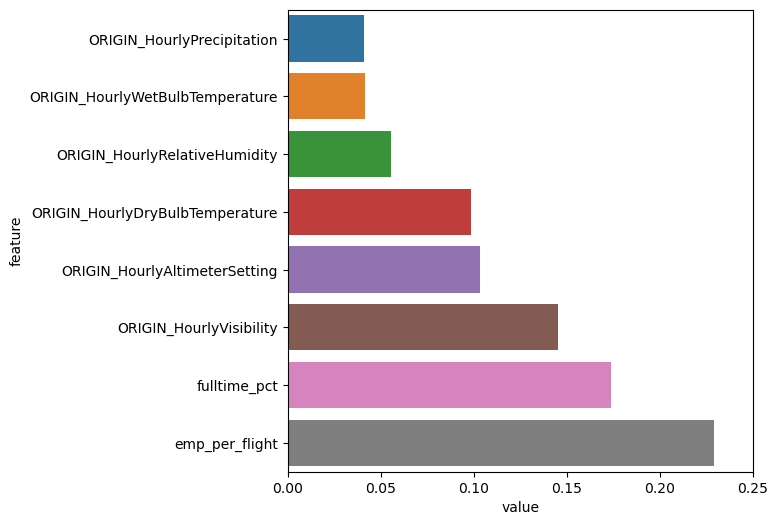

In [40]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.barplot(data=importances_df[9:], x='value', y='feature').set(xlim=(0,0.25))

<BarContainer object of 17 artists>

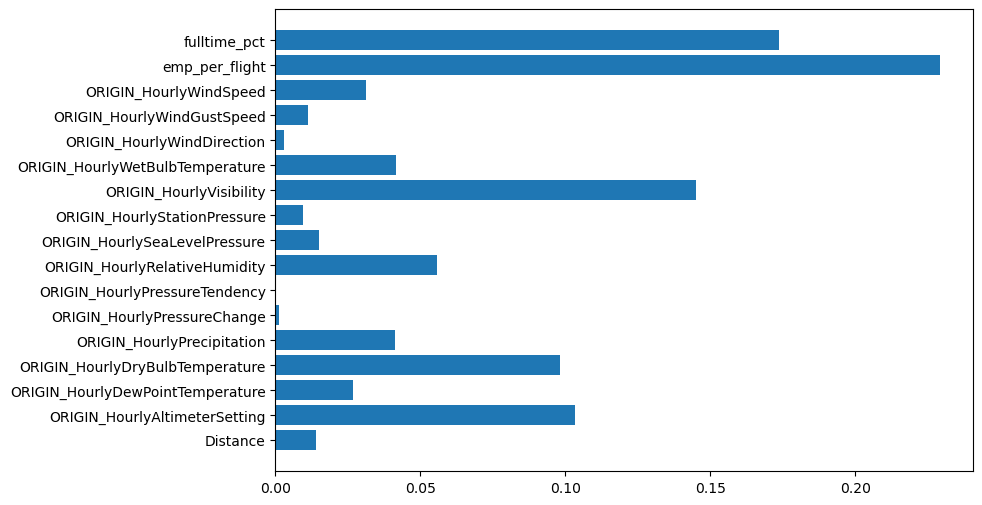

In [38]:
plt.figure(figsize=(9,6))
plt.barh(importances_df['feature'],
        importances_df['value'])

In [ ]:
# TAKING A LONG TIME
# grid search and fine tuning
result = []
f1_max = 0
for numT in [300,400]:
    for maxD in [6,8]:
        for maxB in [64, 128]:
            rfc= RandomForestClassifier(numTrees=numT,
                            maxBins = maxB,
                            maxDepth=maxD, 
                            labelCol='LabelCancelled', 
                            featuresCol='features',
                            weightCol='weight',
                            seed=42)
            rfc_model= rfc.fit(train_df)
            preds= rfc_model.transform(test_df) 
            f1 = evaluator.evaluate(preds, {evaluator.metricName: "f1"})
            acc = evaluator.evaluate(preds, {evaluator.metricName: "accuracy"})
            result.append({
                'numT': numT,
                'maxD': maxD,
                'maxB': maxB,
                'f1': f1,
                'acc': acc
            })
            if f1 > f1_max:
                f1_max = f1
                rfc_model.write().overwrite().save('gs://airline_project/rf_model_weighted')
            print('numTree: ', numT, 'maxDepth: ', maxD, 'maxBins: ', maxB, 'f1: ', f1, 'Accuraacy: ', acc)

22/11/30 07:27:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/11/30 07:45:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/30 08:04:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/11/30 08:07:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB


numTree:  300 maxDepth:  6 maxBins:  64 f1:  0.8595425816785988 Accuraacy:  0.8056897386390715


22/11/30 09:04:15 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1340.1 KiB
22/11/30 09:22:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/11/30 09:43:49 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/11/30 09:46:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.1 MiB


numTree:  300 maxDepth:  6 maxBins:  128 f1:  0.8678510794620975 Accuraacy:  0.8190258322362242


22/11/30 10:43:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1333.0 KiB
22/11/30 11:01:44 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/11/30 11:22:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/11/30 11:44:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1385.3 KiB
22/11/30 11:45:16 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/11/30 12:11:06 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
